# Titanic: Machine Learning from Disaster

In this project, we will work in the competition from [Kaggle](https://www.kaggle.com/c/titanic/data). In this competition, the two files are named test.csv and train.csv. Files have data about passengers abroad in titanic. The filesare available on the data page for the Titanic competition on [Kaggle](https://www.kaggle.com/c/titanic/data). That page also has a data dictionary, which explains the various columns that make up the data set. Below are the descriptions contained in that data dictionary:

- PassengerID - A column added by Kaggle to identify each row and make submissions easier
- Survived - Whether the passenger survived or not and the value we are predicting (0=No, 1=Yes)
- Pclass - The class of the ticket the passenger purchased (1=1st, 2=2nd, 3=3rd)
- Sex - The passenger's sex
- Age - The passenger's age in years
- SibSp - The number of siblings or spouses the passenger had aboard the Titanic
- Parch - The number of parents or children the passenger had aboard the Titanic
- Ticket - The passenger's ticket number
- Fare - The fare the passenger paid
- Cabin - The passenger's cabin number
- Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

The data page on Kaggle has some additional notes about some of the columns. It's always worth exploring this in detail to get a full understanding of the data.

## Getting started

In [1]:
#read in the data
import pandas as pd

test = pd.read_csv("test.csv")
test_shape = test.shape
train = pd.read_csv("train.csv")
train_shape = train.shape
print(test_shape, train_shape)

(418, 11) (891, 12)


In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The type of machine learning we will be doing is called classification, because when we make predictions we are classifying each passenger as a survivor or not. More specifically, we are performing binary classification, which means that there are only two different states we are classifying. 

In this case, understanding the Titanic disaster and specifically what variables might affect the outcome of survival is important. Anyone who has watched the movie Titanic would remember that women and children were given preference to lifeboats (as they were in real life). You would also remember the vast class disparity of the passengers.

This indicates that Age, Sex, and PClass may be good predictors of survival. We'll start by exploring Sex and Pclass by visualizing the data.

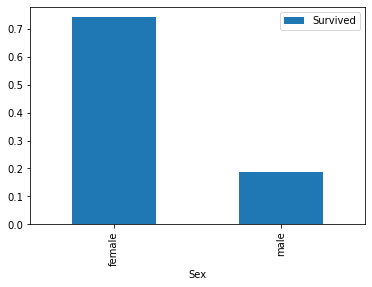

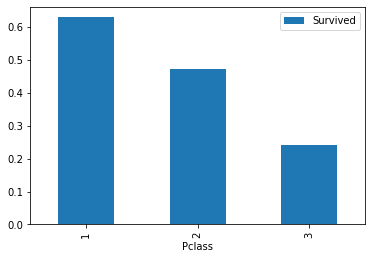

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot.plot.bar()
plt.show()

pclass_pivot = train.pivot_table(index="Pclass",values="Survived")
pclass_pivot.plot.bar()
plt.show()

We can immediately see that females survived in much higher proportions than males did. The Sex and PClass columns are what we call categorical features. That means that the values represented a few separate options (for instance, whether the passenger was male or female). Let's take a look at the Age column.

In [4]:
print(train["Age"].describe())

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


The Age column contains numbers ranging from 0.42 to 80.0 (if you look at Kaggle's data page, it informs us that Age is fractional if the passenger is less than one). The other thing to note here is that there are 714 values in this column, fewer than the 891 rows we discovered that the train data set had earlier in this mission which indicates we have some missing values.

All of this means that the Age column needs to be treated slightly differently, as this is a continuous numerical column. One way to look at distribution of values in a continuous numerical set is to use histograms. We can create two histograms to compare visually those that survived vs those who died across different age ranges:

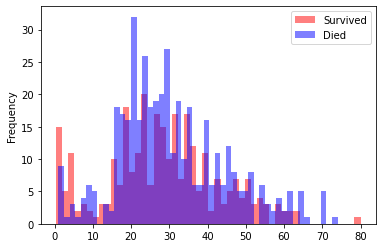

In [5]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

The relationship here is not simple, but we can see that in some age ranges more passengers survived - where the red bars are higher than the blue bars.

In order for this to be useful to our machine learning model, we can separate this continuous feature into a categorical feature by dividing it into ranges.

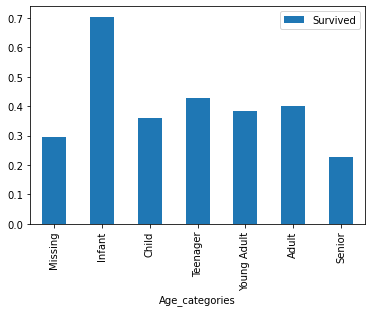

In [6]:
#dividing age into ranges and put missing to missing values

def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0,5,12,18,35,60,100]
label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

Age_categories_pivot = train.pivot_table(index="Age_categories",values="Survived")
Age_categories_pivot.plot.bar()
plt.show()

So far we have identified three columns that may be useful for predicting survival:

- Sex
- Pclass
- Age, or more specifically our newly created Age_categories

Before we build our model, we need to prepare these columns for machine learning. Most machine learning algorithms can't understand text labels, so we have to convert our values into numbers.

Additionally, we need to be careful that we don't imply any numeric relationship where there isn't one. If we think of the values in the Pclass column, we know they are 1, 2, and 3. You can confirm this by running the following code:

In [7]:
train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
#Create dummies to use in machine learning models for categorical columns(Sex, Pclass, Age_categories)
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")
train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")
train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

## Predicting with Machine Learning Model
Now that our data has been prepared, we are ready to train our first model. The first model we will use is called Logistic Regression, which is often the first model you will train when performing classification.

In [9]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])


LogisticRegression()

But before we going further, we need to think about the accuracy of the prediction. We could also fit and predict on our train dataframe, however if we do this there is a high likelihood that our model will overfit, which means it will perform well because we're testing on the same data we've trained on, but then perform much worse on new, unseen data.

Instead we can split our train dataframe into two:

- One part to train our model on (often 80% of the observations)
- One part to make predictions with and test our model (often 20% of the observations)

So, for now, we change the name of the test dataset to holdout until we ready to work on the test dataset for kaggle

In [10]:
holdout = test # from now on we will refer to this
               # dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.2,random_state=0)

Now that we have our data split into train and test sets, we can fit our model again on our training set, and then use that model to make predictions on our test set. There are a number of ways to measure the accuracy of machine learning models, but when competing in Kaggle competitions you want to make sure you use the same method that Kaggle uses to calculate accuracy for that specific competition.

In this case, the [evaluation section for the Titanic competition](https://www.kaggle.com/c/titanic#evaluation) on Kaggle tells us that our score calculated as "the percentage of passengers correctly predicted". This is by far the most common form of accuracy for binary classification.

In [11]:
#fit the model, predict the Survived value and check out the accuracy
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)

accuracy = accuracy_score(test_y, predictions)
accuracy

0.8100558659217877

Our model has an accuracy score of 81.0% when tested against our 20% test set. Given that this data set is quite small, there is a good chance that our model is overfitting, and will not perform as well on totally unseen data.

To give us a better understanding of the real performance of our model, we can use a technique called cross validation to train and test our model on different splits of our data, and then average the accuracy scores.

In [12]:
from sklearn.model_selection import cross_val_score
import numpy as np

lr = LogisticRegression()

scores=cross_val_score(lr, all_X, all_y, cv=10)
accuracy = np.mean(scores)
print(scores)
print(accuracy)

[0.8        0.82022472 0.76404494 0.87640449 0.80898876 0.78651685
 0.76404494 0.76404494 0.83146067 0.80898876]
0.8024719101123596


From the results of our k-fold validation, we can see that the accuracy number varies with each fold - ranging between 76.4% and 87.6%. This demonstrates why cross validation is important.

As it happens, our average accuracy score was 80.2%, which is not far from the 81.0% we got from our simple train/test split, however this will not always be the case, and we should always use cross-validation to make sure the error metrics you are getting from your model are accurate.

We are now ready to use the model we have built to train our final model and then make predictions on our unseen holdout data, or what Kaggle calls the 'test' data set.

In [13]:
#prediction on holdout dataset
lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])

## Preparing Submission

The last thing we need to do is create a submission file. Each Kaggle competition can have slightly different requirements for the submission file. Here's what is specified on the Titanic competition evaluation page:

You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

- PassengerId (sorted in any order)
- Survived (contains your binary predictions: 1 for survived, 0 for deceased)

In [14]:
#Create submisssion dataframe
submission = pd.DataFrame()
submission["PassengerId"]= holdout["PassengerId"]
submission["Survived"] = holdout_predictions

In [15]:
#Create csv file to submit
submission.to_csv("submission.csv",index=False)

## First Conclusion

After the submission, our prediction scored 76.3% compared with the 80.2% accuracy we got with cross-validation indicates that our model is overfitting slightly to our training data. 76.3% can be seem little low but there is a great analysis on Kaggle, [How am I doing with my score](https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score/notebook), which uses a few different strategies and suggests a minimum score for this competition is 62.7% (achieved by presuming that every passenger died) and a maximum of around 82%. We are a little over halfway between the minimum and maximum, which is a great starting point.

There are many things we can do to improve the accuracy of our model. Here are some that we can go further:

- Improving the features:
    - Feature Engineering: Create new features from the existing data.
    - Feature Selection: Select the most relevant features to reduce noise and overfitting.
- Improving the model:
    - Model Selection: Try a variety of models to improve performance.
    - Hyperparameter Optimization: Optimize the settings within each particular machine learning model.

## Feature Engineering

Our model in the previous mission was based on three columns from the original data: Age, Sex, and Pclass. As you saw when you printed the column names in the previous screen, there are a number of other columns that we haven't yet used. We can see columns we didn't use from the full columns list below.

In [16]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior'],
      dtype='object')

The last nine rows of the output are dummy columns we created, but in the first three rows we can see there are a number of features we haven't yet utilized. We can ignore PassengerId, since this is just a column Kaggle have added to identify each passenger and calculate scores. We can also ignore Survived, as this is what we're predicting, as well as the three columns we've already used.

Here is a list of the remaining columns (with a brief description), followed by 10 randomly selected passengers from and their data from those columns, so we can refamiliarize ourselves with the data.

- SibSp - The number of siblings or spouses the passenger had aboard the Titanic
- Parch - The number of parents or children the passenger had aboard the Titanic
- Ticket - The passenger's ticket number
- Fare - The fair the passenger paid
- Cabin - The passengers cabin number
- Embarked - The port where the passenger embarked (C=Cherbourg, Q=Queenstown, S=Southampton)

At first glance, both the Name and Ticket columns look to be unique to each passenger. We will come back to these columns later, but for now we'll focus on the other columns.

In [17]:
columns = ['SibSp','Parch','Fare','Cabin','Embarked']
train[columns].describe(include='all',percentiles=[])

,SibSp,Parch,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,204,889
unique,NaN,NaN,NaN,147,3
top,NaN,NaN,NaN,G6,S
freq,NaN,NaN,NaN,4,644
mean,0.523008,0.381594,32.204208,NaN,NaN
std,1.102743,0.806057,49.693429,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
max,8.000000,6.000000,512.329200,NaN,NaN


Of these, SibSp, Parch and Fare look to be standard numeric columns with no missing values. Cabin has values for only 204 of the 891 rows, and even then most of the values are unique, so for now we will leave this column also. Embarked looks to be a standard categorical column with 3 unique values, much like PClass was, except that there are two missing values. We can easily fill these two missing values with the most common value, "S" which occurs 644 times.

Looking at our numeric columns, we can see a big difference between the range of each. SibSp has values between 0-8, Parch between 0-6, and Fare is on a dramatically different scale, with values ranging from 0-512. In order to make sure these values are equally weighted within our model, we'll need to rescale the data.

In [18]:
holdout[columns].describe(include='all',percentiles=[])

,SibSp,Parch,Fare,Cabin,Embarked
count,418.000000,418.000000,417.000000,91,418
unique,NaN,NaN,NaN,76,3
top,NaN,NaN,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,NaN,3,270
mean,0.447368,0.392344,35.627188,NaN,NaN
std,0.896760,0.981429,55.907576,NaN,NaN
min,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,14.454200,NaN,NaN
max,8.000000,9.000000,512.329200,NaN,NaN


In [19]:
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

In [20]:
#Work out for embarked first
#fill missing value with S which is the most frequent value
train["Embarked"] = train["Embarked"].fillna("S")
holdout["Embarked"] = holdout["Embarked"].fillna("S")
#Create dummies for the model
train = create_dummies(train, "Embarked")
holdout = create_dummies(holdout, "Embarked")

In [21]:
#Scale the values and create another columns for those
from sklearn.preprocessing import minmax_scale
columns = ["SibSp","Parch","Fare"]
for col in columns:
    train[col + "_scaled"] = minmax_scale(train[col])
    holdout[col + "_scaled"] = minmax_scale(holdout[col])

In order to select the best-performing features, we need a way to measure which of our features are relevant to our outcome - in this case, the survival of each passenger. One effective way is by training a logistic regression model using all of our features, and then looking at the coefficients of each feature.

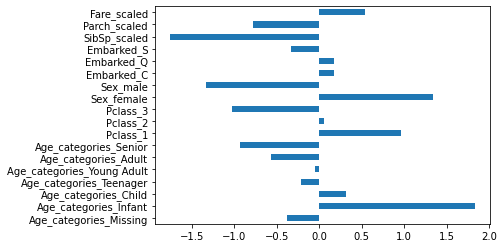

In [22]:
columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns], train["Survived"])
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index=columns)
feature_importance.plot.barh()

The plot we generated in the last screen showed a range of both positive and negative values. Whether the value is positive or negative isn't as important in this case, relative to the magnitude of the value. A feature that indicates strongly whether a passenger died is just as useful as a feature that indicates strongly that a passenger survived, given they are mutually exclusive outcomes.

To make things easier to interpret, we'll alter the plot to show all positive values, and have sorted the bars in order of size:

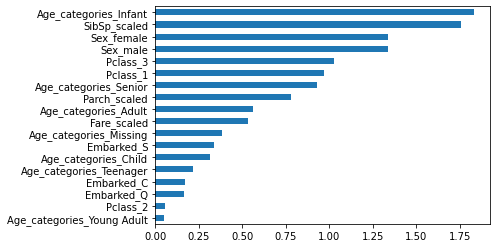

In [23]:
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

We'll train a new model with the top 8 scores and check our accuracy using cross validation.

In [24]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
print(accuracy)

0.8148064918851435


The cross validation score of 81.48% is marginally higher than the cross validation score for the model we created previously, which had a score of 80.2%.

Hopefully, this improvement will translate to previously unseen data. Let's train a model using the columns from the previous step, make some predictions on the holdout data and submit it to Kaggle for scoring.

In [25]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr=LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[columns])

submission = pd.DataFrame()

submission["PassengerId"] = holdout["PassengerId"]
submission["Survived"]= holdout_predictions

submission.to_csv("submission_1.csv",index=False)

## Binning
When we submit it to Kaggle, we see that the score is 77.8%. It's only a small improvement, but we're moving in the right direction.

A lot of the gains in accuracy in machine learning come from Feature Engineering. Feature engineering is the practice of creating new features from our existing data.

One common way to engineer a feature is using a technique called binning. Binning is when we take a continuous feature, like the fare a passenger paid for their ticket, and separate it out into several ranges (or 'bins'), turning it into a categorical variable.

This can be useful when there are patterns in the data that are non-linear and you're using a linear model (like logistic regression). We actually used binning in the previous mission when we dealt with the Age column, although we didn't use the term.

Let's look at histograms of the Fare column for passengers who died and survived, and see if there are patterns that we can use when creating our bins.

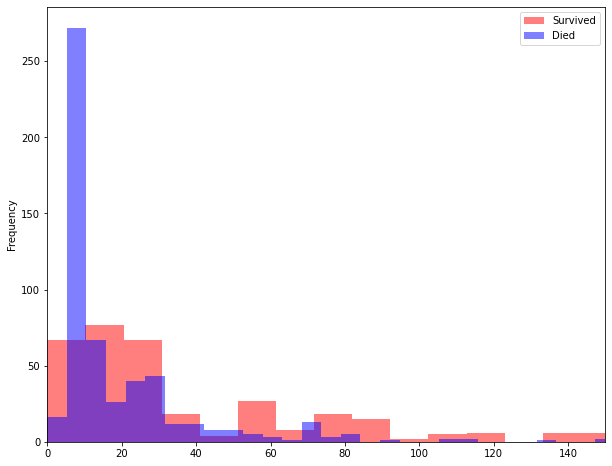

In [26]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
plt.figure(figsize=(10,8))
survived["Fare"].plot.hist(alpha=0.5,color='red',bins=50)
died["Fare"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.xlim(0, 150)
plt.show()

Looking at the values, it looks like we can separate the feature into four bins to capture some patterns from the data:

- 0-12
- 12-50
- 50-100
- 100+

In [27]:
#Create the process_fare function and use it for train and holdout data
def process_fare(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0,12,50,100,1000]
label_names = ["0-12","12-50","50-100","100+"]

train = process_fare(train,cut_points,label_names)
holdout = process_fare(holdout,cut_points,label_names)
#Create dummies for machine learning columns
train = create_dummies(train,"Fare_categories")
holdout = create_dummies(holdout,"Fare_categories")

Another way to engineer features is by extracting data from text columns. Earlier, we decided that the Name and Cabin columns weren't useful by themselves, but what if there is some data there we could extract? Let's take a look at a random sample of rows from those two columns:
<table>
<thead>
  <tr>
    <th></th>
    <th>Name</th>
    <th>Cabin</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>772</td>
    <td>Mack, Mrs. (Mary)</td>
    <td>E77</td>
  </tr>
  <tr>
    <td>148</td>
    <td>Navratil, Mr. Michel ("Louis M Hoffman")</td>
    <td>F2</td>
  </tr>
  <tr>
    <td>707</td>
    <td>Calderhead, Mr. Edward Pennington</td>
    <td>E24</td>
  </tr>
  <tr>
    <td>879</td>
    <td>Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)</td>
    <td>C50</td>
  </tr>
  <tr>
    <td>21</td>
    <td>Beesley, Mr. Lawrence</td>
    <td>D56</td>
  </tr>
  <tr>
    <td>456</td>
    <td>Millet, Mr. Francis Davis</td>
    <td>E38</td>
  </tr>
  <tr>
    <td>97</td>
    <td>Greenfield, Mr. William Bertram</td>
    <td>D10 D12</td>
  </tr>
  <tr>
    <td>263</td>
    <td>Harrison, Mr. William</td>
    <td>B94</td>
  </tr>
  <tr>
    <td>393</td>
    <td>Newell, Miss. Marjorie</td>
    <td>D36</td>
  </tr>
  <tr>
    <td>759</td>
    <td>Rothes, the Countess. of (Lucy Noel Martha Dye...</td>
    <td>B77</td>
  </tr>
</tbody>
</table>

While in isolation the cabin number of each passenger will be reasonably unique to each, we can see that the format of the cabin numbers is one letter followed by two numbers. It seems like the letter is representative of the type of cabin, which could be useful data for us.

In [28]:
print(train.head()["Cabin"].str[0])

0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Cabin, dtype: object


Looking at the Name column, There is a title like 'Mr' or 'Mrs' within each, as well as some less common titles, like the 'Countess' from the final row of our table above. By spending some time researching the different titles, we can categorize these into six types:

- Mr
- Mrs
- Master
- Miss
- Officer
- Royalty

In [29]:
#Get all titles, map them to 6 types above.
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}
#Extract titles using re and mapping with map created above
extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
extracted_titles_holdout = holdout["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)
holdout["Title"] = extracted_titles_holdout.map(titles)
#extract the first letter of cabin to determine the cabin type and filling missing value with unknown
train["Cabin_type"] = train["Cabin"].str[0].fillna("Unknown")
holdout["Cabin_type"] = holdout["Cabin"].str[0].fillna("Unknown")
#create dummies for title and cabin type
for column in ["Title","Cabin_type"]:
    train = create_dummies(train,column)
    holdout = create_dummies(holdout,column)

We now have 34 possible feature columns we can use to train our model. One thing to be aware of as we start to add more features is a concept called collinearity. Collinearity occurs where more than one feature contains data that are similar.

The effect of collinearity is that our model will overfit -we may get great results on our test data set, but then the model performs worse on unseen data (like the holdout set).

One easy way to understand collinearity is with a simple binary variable like the Sex column in our dataset. Every passenger in our data is categorized as either male or female, so 'not male' is exactly the same as 'female'.

As a result, when we created our two dummy columns from the categorical Sex column, we've actually created two columns with identical data in them. This will happen whenever we create dummy columns, and is called the dummy variable trap. The easy solution is to choose one column to drop any time you make dummy columns.

The easiest way to check collinearity is using the DataFrame.corr() method to produce a correlation matrix, and then use the Seaborn library's seaborn.heatmap() function to plot the values

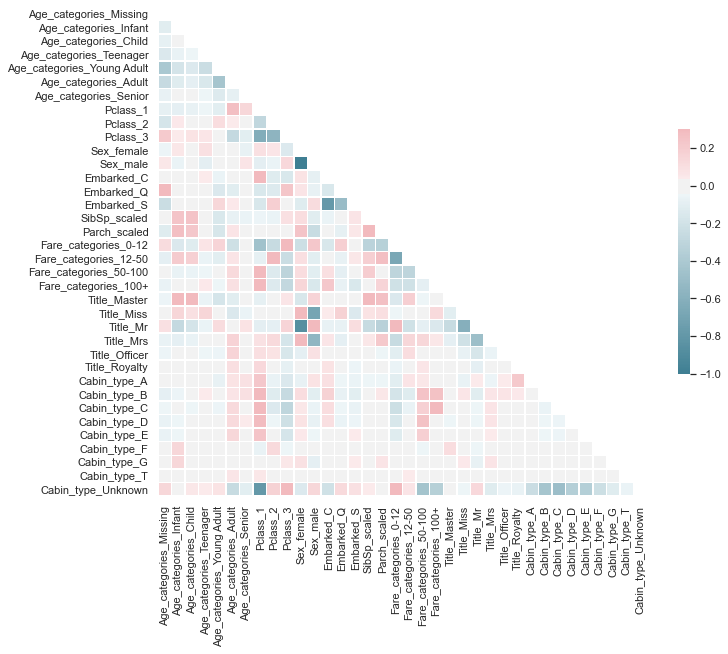

In [30]:
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

We can see that there is a high correlation between Sex_female/Sex_male and Title_Miss/Title_Mr/Title_Mrs. We will remove the columns Sex_female and Sex_male since the title data may be more nuanced.

Apart from that, we should remove one of each of our dummy variables to reduce the collinearity in each. We'll remove:

- Pclass_2
- Age_categories_Teenager
- Fare_categories_12-50
- Title_Master
- Cabin_type_A

In an earlier step, we manually used the logit coefficients to select the most relevant features. An alternate method is to use one of scikit-learn's inbuilt feature selection classes. We will be using the feature_selection.RFECV class which performs recursive feature elimination with cross-validation.

In [31]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]
lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(all_X,all_y)

optimized_columns = all_X.columns[selector.support_]
optimized_columns

Index(['SibSp_scaled', 'Title_Mr', 'Title_Officer', 'Cabin_type_Unknown'], dtype='object')

Let's train a model using cross validation using these columns and check the score.

In [32]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = np.mean(scores)
print(accuracy)

0.8226591760299625


This four-feature model scores 82.3%, a modest improvement compared to the 81.5% from our earlier model. Let's train these columns on the holdout set, save a submission file and see what score we get from Kaggle.

In [33]:
lr = LogisticRegression()
lr.fit(all_X,all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

submission = pd.DataFrame()

submission["PassengerId"] = holdout["PassengerId"]
submission["Survived"]= holdout_predictions

submission.to_csv("submission_2.csv",index=False)

## Second conclusion

By preparing, engineering and selecting features, we have increased our accuracy by 1.5%. When working in Kaggle competitions, you should spend a lot of time experimenting with features, particularly feature engineering.

Here are some ideas that you can use to work with features for this competition:

- Use SibSp and Parch to explore total relatives onboard.
- Create combinations of multiple columns, for instance Pclass + Sex.
- See if you can extract useful data out of the Ticket column.
- Try different combinations of features to see if you can identify features that overfit less than others.

## Model Selection and Tuning
We worked to optimize our predictions by creating and selecting the features used to train our model. The other half of the optimization puzzle is to optimize the model itself— or more specifically, the algorithm used to train our model.

So far, we've been using the logistic regression algorithm to train our models, however there are hundreds of different machine learning algorithms from which we can choose. Each algorithm has different strengths and weaknesses, and so we need to select the algorithm that works best with our specific data— in this case our Kaggle competition.

The process of selecting the algorithm which gives the best predictions for our data is called model selection.

In this mission, we're going to work with two new algorithms: k-nearest neighbors and random forests.

We're going to train our models using all the columns in the train dataframe. This will cause a small amount of overfitting due to collinearity, but having more features will allow us to more thoroughly compare algorithms.

So we have something to compare to, we're going to train a logistic regression model. We'll use cross validation to get a baseline score.

In [34]:
#load the saved csv file with only columns we created in feature engineering with survived
train = pd.read_csv('train_modified.csv')
holdout = pd.read_csv('holdout_modified.csv')

In [35]:
all_X = train.drop(['Survived','PassengerId'],axis=1)
all_y = train['Survived']

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy_lr = np.mean(scores)
accuracy_lr

0.8249812734082397

The logistic regression baseline model scored 82.4%.
<table>
<thead>
  <tr>
    <th>Model</th>
    <th>Cross-validation score</th>
    <th>Kaggle score</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Previous best Kaggle score</td>
    <td>82.3%</td>
    <td>78.0%</td>
  </tr>
  <tr>
    <td>Logistic regression baseline</td>
    <td>82.4%</td>
    <td></td>
  </tr>
</tbody>
</table>

## K-Nearest Neighbors
The k-nearest neighbors algorithm finds the observations in our training set most similar to the observation in our test set, and uses the average outcome of those 'neighbor' observations to make a prediction. The 'k' is the number of neighbor observations used to make the prediction.

The plots below shows three simple k-nearest neighbors models where there are two features shown on each axis, and two outcomes, red and green.
![img](https://s3.amazonaws.com/dq-content/187/knn_overview.svg)

- In the first plot, the value of k is 1, so the closest 1 neighbor to our gray dot is used, green, making the prediction green.
- In the second plot, the value of k is 3, so the closest 3 neighbors to our gray dot are used, green, making the prediction red (2 red vs 1 green).
- In the third plot, the value of k is 5, so the closest 5 neighbors to our gray dot are used, green, making the prediction red (3 red vs 2 green).

In [36]:
#Using KNeighbors, get the accuracy score
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

scores = cross_val_score(knn, all_X, all_y, cv=10)
accuracy_knn = scores.mean()
accuracy_knn

0.7833832709113608

The k-nearest neighbors model we trained in the previous screen had an accuracy score of 78.6%, worse than our baseline score of 82.4%.
<table>
<thead>
  <tr>
    <th>Model</th>
    <th>Cross-validation score</th>
    <th>Kaggle score</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Previous best Kaggle score</td>
    <td>82.3%</td>
    <td>78.0%</td>
  </tr>
  <tr>
    <td>Logistic regression baseline</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 1</td>
    <td>78.6%</td>
    <td></td>
  </tr>
</tbody>
</table>
Besides pure model selection, we can vary the settings of each model— for instance the value of k in our k-nearest neighbors model. This is called hyperparameter optimization.

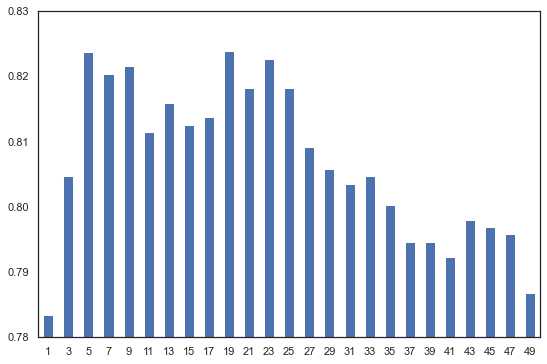

In [37]:
#Let's differrentiate the k value for odd numbers in 1~50 and check out the accuracy.
knn_scores = dict()

for k in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, all_X, all_y, cv=10)
    accuracy_knn = np.mean(scores)
    knn_scores[k]=accuracy_knn
#plotting accuracy for each k value to find out the best
def plot_dict(dictionary):
    pd.Series(dictionary).plot.bar(figsize=(9,6),
                                   ylim=(0.78,0.83),rot=0)
    plt.show()
    
plot_dict(knn_scores)

In [38]:
knn_scores

{1: 0.7833832709113608,
 3: 0.804756554307116,
 5: 0.8237702871410736,
 7: 0.8204119850187265,
 9: 0.8215355805243446,
 11: 0.8114856429463171,
 13: 0.8159800249687891,
 15: 0.812621722846442,
 17: 0.8137702871410737,
 19: 0.8238576779026218,
 21: 0.8182022471910113,
 23: 0.8226841448189763,
 25: 0.8181897627965045,
 27: 0.8092009987515606,
 29: 0.8058426966292135,
 31: 0.8035705368289637,
 33: 0.8047191011235956,
 35: 0.8002122347066167,
 37: 0.7946192259675405,
 39: 0.7946192259675406,
 41: 0.7923845193508114,
 43: 0.7980024968789013,
 45: 0.7968789013732833,
 47: 0.7957677902621723,
 49: 0.7867915106117352}

Looking at our plot, we can see that a k value of 19 gave us our best score, and checking the knn_scores dictionary we can see that the score was 82.4%, identical to our baseline.
<table>
<thead>
  <tr>
    <th>Model</th>
    <th>Cross-validation score</th>
    <th>Kaggle score</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Previous best Kaggle score</td>
    <td>82.3%</td>
    <td>78.0%</td>
  </tr>
  <tr>
    <td>Logistic regression baseline</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 1</td>
    <td>78.6%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 19</td>
    <td>82.4%</td>
    <td></td>
  </tr>
</tbody>
</table>

In [39]:
#The gridseach we just did above also can be achieved by GridSearchCV in sklearn
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

hyperparameters = {
    "n_neighbors": range(1,50,2)
}
grid = GridSearchCV(knn, param_grid=hyperparameters, cv=10)
grid.fit(all_X, all_y)

print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 19}
0.8238576779026218


Let's use GridSearchCV to turbo-charge our search for the best performing parameters for our model, by testing 40 combinations of three different hyperparameters.

In [40]:
hyperparameters = {
    "n_neighbors": range(1,20,2),
    "weights": ["distance", "uniform"],
    "algorithm": ['brute'],
    "p": [1,2]
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_

In [41]:
print(best_params)
print(best_score)

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.8293882646691635


The cross-validation score for the best performing model was 82.9%, better than our baseline model.
<table>
<thead>
  <tr>
    <th>Model</th>
    <th>Cross-validation score</th>
    <th>Kaggle score</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Previous best Kaggle score</td>
    <td>82.3%</td>
    <td>78.0%</td>
  </tr>
  <tr>
    <td>Logistic regression baseline</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 1</td>
    <td>78.6%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 19</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, best model from grid search</td>
    <td>82.9%</td>
    <td></td>
  </tr>
</tbody>
</table>

In [42]:
#Use best_estimated knn to predict the holdout dataset and prepare the submission file
holdout_no_id = holdout.drop(['PassengerId'],axis=1)
best_knn = grid.best_estimator_
holdout_predictions = best_knn.predict(holdout_no_id)

submission = pd.DataFrame()

submission["PassengerId"] = holdout["PassengerId"]
submission["Survived"]= holdout_predictions

submission.to_csv("submission_3.csv",index=False)

When we submit this to Kaggle, we'll see it scores 75.6%, less than our best submission of 78.0%. While our model could be overfitting due to including all columns, it also seems like k-nearest neighbors may not be the best algorithm choice.
<table>
<thead>
  <tr>
    <th>Model</th>
    <th>Cross-validation score</th>
    <th>Kaggle score</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Previous best Kaggle score</td>
    <td>82.3%</td>
    <td>78.0%</td>
  </tr>
  <tr>
    <td>Logistic regression baseline</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 1</td>
    <td>78.6%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 19</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, best model from grid search</td>
    <td>82.9%</td>
    <td>75.6%</td>
  </tr>
</tbody>
</table>

## Random Forest
Let's try another algorithm called random forests. Random forests is a specific type of decision tree algorithm. 

In [43]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=1)
scores = cross_val_score(clf, all_X, all_y, cv=10)
accuracy_rf = scores.mean()
accuracy_rf

0.8204119850187267

Using the default settings, our random forests model obtained a cross validation score of 82.0%.
<table>
<thead>
  <tr>
    <th>Model</th>
    <th>Cross-validation score</th>
    <th>Kaggle score</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Previous best Kaggle score</td>
    <td>82.3%</td>
    <td>78.0%</td>
  </tr>
  <tr>
    <td>Logistic regression baseline</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 1</td>
    <td>78.6%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 19</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, best model from grid search</td>
    <td>82.9%</td>
    <td>75.6%</td>
  </tr>
  <tr>
    <td>Random forests, default hyperparameters</td>
    <td>82.0%</td>
    <td></td>
  </tr>
</tbody>
</table>

Just like we did with the k-nearest neighbors model, we can use GridSearchCV to test a variety of hyperparameters to find the best performing model.

In [44]:
#hyperparameters to check
hyperparameters = {"criterion": ["entropy", "gini"],
                   "max_depth": [5, 10],
                   "max_features": ["log2", "sqrt"],
                   "min_samples_leaf": [1, 5],
                   "min_samples_split": [3, 5],
                   "n_estimators": [6, 9]
}

clf = RandomForestClassifier(random_state=1)
grid = GridSearchCV(clf,param_grid=hyperparameters,cv=10)

grid.fit(all_X, all_y)

best_params = grid.best_params_
best_score = grid.best_score_
print(best_params)
print(best_score)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}
0.838414481897628


The cross-validation score for the best performing model was 83.8%, making it the best cross-validation score we've obtained in this mission.
<table>
<thead>
  <tr>
    <th>Model</th>
    <th>Cross-validation score</th>
    <th>Kaggle score</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Previous best Kaggle score</td>
    <td>82.3%</td>
    <td>78.0%</td>
  </tr>
  <tr>
    <td>Logistic regression baseline</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 1</td>
    <td>78.6%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 19</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, best model from grid search</td>
    <td>82.9%</td>
    <td>75.6%</td>
  </tr>
  <tr>
    <td>Random forests, default hyperparameters</td>
    <td>82.0%</td>
    <td></td>
  </tr>
  <tr>
    <td>Random forests, best model from grid search</td>
    <td>83.8%</td>
    <td></td>
  </tr>
</tbody>
</table>
Let's train it on the holdout data and create a submission file to see how it performs on the Kaggle leaderboard!

In [45]:
best_rf = grid.best_estimator_
holdout_predictions = best_rf.predict(holdout_no_id)

holdout_ids = holdout["PassengerId"]
submission = pd.DataFrame()
submission["PassengerId"] = holdout["PassengerId"]
submission["Survived"]= holdout_predictions

submission.to_csv("submission_4.csv",index=False)

When we submit this to Kaggle, it achieves a score of 76.8%, considerably better than our k-nearest neighbors score of 75.6% and very close (2 incorrect predictions) to our best score from the previous mission of 78.0%.
<table>
<thead>
  <tr>
    <th>Model</th>
    <th>Cross-validation score</th>
    <th>Kaggle score</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>Previous best Kaggle score</td>
    <td>82.3%</td>
    <td>78.0%</td>
  </tr>
  <tr>
    <td>Logistic regression baseline</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 1</td>
    <td>78.6%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, k == 19</td>
    <td>82.4%</td>
    <td></td>
  </tr>
  <tr>
    <td>K-nearest neighbors, best model from grid search</td>
    <td>82.9%</td>
    <td>75.6%</td>
  </tr>
  <tr>
    <td>Random forests, default hyperparameters</td>
    <td>82.0%</td>
    <td></td>
  </tr>
  <tr>
    <td>Random forests, best model from grid search</td>
    <td>83.8%</td>
    <td>76.8%</td>
  </tr>
</tbody>
</table>

By combining our strategies for feature selection, feature engineering, model selection and model tuning, we'll be able to continue to improve our score.

## Combining everything
Now, we will combine everything we did above to make a full cycle of workflow.
The Kaggle workflow we are going to build will combine all of these into a process.
![img](https://s3.amazonaws.com/dq-content/188/kaggle_workflow.svg)

- Data exploration, to find patterns in the data
- Feature engineering, to create new features from those patterns or through pure experimentation
- Feature selection, to select the best subset of our current set of features
- Model selection/tuning, training a number of models with different hyperparameters to find the best performer.

We can continue to repeat this cycle as we work to optimize our predictions. At the end of any cycle we wish, we can also use our model to make predictions on the holdout set and then Submit to Kaggle to get a leaderboard score.

While the first two steps of our workflow are relatively freeform, later in this project we'll create some functions that will help automate the complexity of the latter two steps so we can move faster.

In [46]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [47]:
# %load functions.py
#Function includes all the performance we performed in above
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [48]:
#pre_processing of dataframe
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories","Fare_categories",
                "Title","Cabin_type","Sex"]:
        df = create_dummies(df,col)
    
    return df

train = pre_process(train)
holdout = pre_process(holdout)

## Exploring Data
For now, let's practice the first stage, exploring the data. We're going to examine the two columns that contain information about the family members each passenger had onboard: SibSp and Parch.

In [49]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SibSp     891 non-null    int64
 1   Parch     891 non-null    int64
 2   Survived  891 non-null    int64
dtypes: int64(3)
memory usage: 21.0 KB


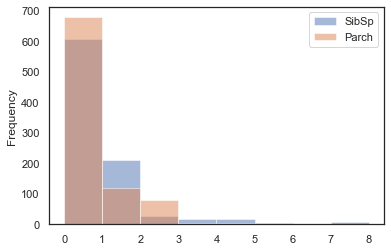

In [50]:
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

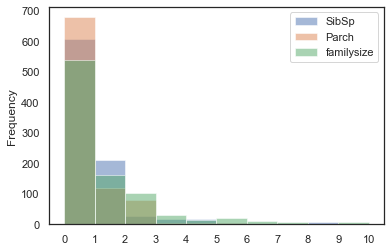

In [51]:
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

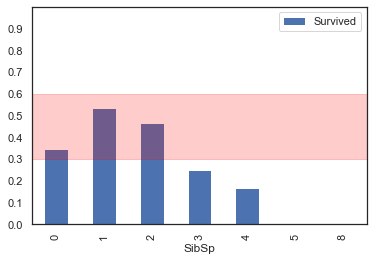

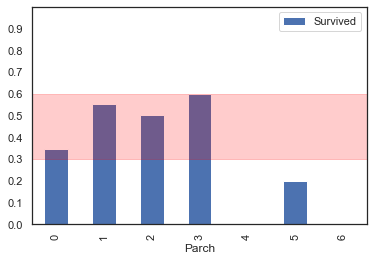

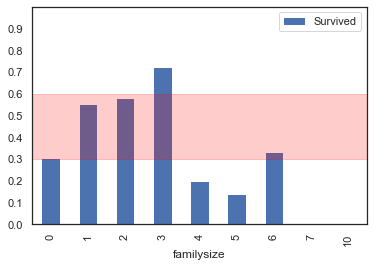

In [52]:
for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

## Engineering New Features

Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

In [53]:
def process_isalone(df):
    df["familysize"] = df[["SibSp","Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

## Selecting the Best-Performing Features
We can write a function that erforms this step for us, which will mean we can perform feature selection by calling a self-contained function and focus our efforts on the more creative part - exploring the data and engineering new features.

Our function will:
- Accepts a dataframe as input
- Performs data preparation for machine learning
- Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

In [54]:
def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



## Selecting and Tuning Different Algorithms
Just like we did with feature selection, we can write a function to do the heavy lifting of model selection and tuning. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries— that is, a list where each element of the list is a dictionary. Each dictionary should contain:

- The name of the particular model
- An estimator object for the model
- A dictionary of hyperparameters that we'll use for grid search.

In [55]:
def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"],
                    "max_iter": [1000]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,cols)

LogisticRegression
------------------
Best Score: 0.8204619225967541
Best Parameters: {'max_iter': 1000, 'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.7767041198501874
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8395505617977527
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 6}



## Making a Submission to Kaggle
After running our function, we have three scores from three different models. At this point in the workflow we have a decision to make: Do we want to train our best model on the holdout set and make a Kaggle submission, or do we want to go back to engineering features.

We may find that adding a feature to our model doesn't improve our accuracy. In that case we should go back to data exploration and repeat the cycle again.

If we're going to be continually submitting to Kaggle, a function will help make this easier. Let's create a function to automate this.

In [56]:
def save_submission_file(model,cols,filename="submission.csv"):
    holdout_data = holdout[cols]
    predictions = model.predict(holdout_data)
    
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids,
                 "Survived": predictions}
    submission = pd.DataFrame(submission_df)

    submission.to_csv(filename,index=False)

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,cols, "submission_5.csv")

## Conclusion
We have successfully made all functions that will perform from pre-processing to save file. Since our best prediction model was randomforestclassifier again, we get the same kaggle score of 76.8%. However, if we tweak the features and model tuning, we can work further to achieve higher score. Here are some suggestions of next steps:

- Continue to explore the data and create new features, following the workflow and using the functions we created.
- Read more about the titanic and this Kaggle competition to get ideas for new features.
- Use some different algorithms in the select_model() function, like support vector machines, stochastic gradient descent or perceptron linear models.
- Experiment with RandomizedSearchCV instead of GridSearchCV to speed up your select_features() function.